In [123]:
#Set up the library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [33]:
#Set up the dataframe
df = pd.read_csv('data/NBA Shot Locations 1997 - 2020.csv')
df.head(3)

,Game ID,Game Event ID,Player ID,Player Name,Team ID,Team Name,Period,Minutes Remaining,Seconds Remaining,Action Type,...,Shot Zone Area,Shot Zone Range,Shot Distance,X Location,Y Location,Shot Made Flag,Game Date,Home Team,Away Team,Season Type
0,29700427,389,100,Tim Legler,1610612764,Washington Wizards,4,11,22,Jump Shot,...,Right Side(R),8-16 ft.,15,117,109,1,19980102,WAS,IND,Regular Season
1,29700427,406,100,Tim Legler,1610612764,Washington Wizards,4,9,36,Jump Shot,...,Right Side(R),8-16 ft.,14,143,25,0,19980102,WAS,IND,Regular Season
2,29700427,475,100,Tim Legler,1610612764,Washington Wizards,4,3,7,Jump Shot,...,Left Side(L),8-16 ft.,10,-87,55,0,19980102,WAS,IND,Regular Season


Lets add more players into the data frame to see if we can improve the results

In [34]:
#Test Data Frame will be these 10 players 
playertest = ['LeBron James', 'Kyle Lowry','Stephen Curry','Kevin Durant',
              'James Harden','Russell Westbrook','Damian Lillard','Kawhi Leonard',
              'Kyrie Irving','Bradley Beal']
test_df=df[df['Player Name'].isin(playertest)]
test_df['Player Name'].value_counts()

LeBron James         29658
Kevin Durant         18731
Russell Westbrook    18547
James Harden         15688
Stephen Curry        14102
Damian Lillard       12040
Kyle Lowry           11180
Kyrie Irving         10486
Bradley Beal          9945
Kawhi Leonard         8565
Name: Player Name, dtype: int64

In [35]:
#Check the columns
test_df.columns

Index(['Game ID', 'Game Event ID', 'Player ID', 'Player Name', 'Team ID',
       'Team Name', 'Period', 'Minutes Remaining', 'Seconds Remaining',
       'Action Type', 'Shot Type', 'Shot Zone Basic', 'Shot Zone Area',
       'Shot Zone Range', 'Shot Distance', 'X Location', 'Y Location',
       'Shot Made Flag', 'Game Date', 'Home Team', 'Away Team', 'Season Type'],
      dtype='object')

Earlier we had a model that was getting too much information from the data, so lets remove some of the columns

In [36]:
#Lets drop the uselss columns, as well as columns that give too much information
DT_df= test_df.drop(['Team ID','Player ID',
                     'Player Name','Game Event ID', 'Team Name','X Location', 'Y Location', 
                     'Home Team','Away Team','Season Type','Action Type','Shot Zone Basic'
                    ],axis=1)

In [37]:
#Get the shape
DT_df.shape

(148942, 10)

In [40]:
#Rebuild the DF
#idka=pd.get_dummies(DT_df['Action Type'])
idkb=pd.get_dummies(DT_df['Shot Type'])
#idkc=pd.get_dummies(DT_df['Shot Zone Basic'])
idkd=pd.get_dummies(DT_df['Shot Zone Range'])
idk = pd.concat([DT_df, idkb, idkd], axis=1, sort=False)
idk=idk.drop(['Shot Type','Shot Zone Range'],axis=1)
idk.head(3)

,Game ID,Period,Minutes Remaining,Seconds Remaining,Shot Zone Area,Shot Distance,Shot Made Flag,Game Date,2PT Field Goal,3PT Field Goal,16-24 ft.,24+ ft.,8-16 ft.,Back Court Shot,Less Than 8 ft.
1194060,20300014,1,8,56,Right Side(R),15,1,20031029,1,0,0,0,1,0,0
1194061,20300014,1,7,44,Left Side(L),13,1,20031029,1,0,0,0,1,0,0
1194062,20300014,1,7,1,Right Side(R),16,1,20031029,1,0,1,0,0,0,0


In [41]:
#Lets drop Back court as there are only 52 shots
idk.drop(idk[idk['Shot Zone Area'] == 'Back Court(BC)'].index,inplace=True)
idk.head(3)

,Game ID,Period,Minutes Remaining,Seconds Remaining,Shot Zone Area,Shot Distance,Shot Made Flag,Game Date,2PT Field Goal,3PT Field Goal,16-24 ft.,24+ ft.,8-16 ft.,Back Court Shot,Less Than 8 ft.
1194060,20300014,1,8,56,Right Side(R),15,1,20031029,1,0,0,0,1,0,0
1194061,20300014,1,7,44,Left Side(L),13,1,20031029,1,0,0,0,1,0,0
1194062,20300014,1,7,1,Right Side(R),16,1,20031029,1,0,1,0,0,0,0


In [42]:
#Roll up the columns
idk.loc[idk['Shot Zone Area'] == 'Left Side Center(LC)' , ['Shot Zone Area']] = 'Left Side(L)'
idk.loc[idk['Shot Zone Area'] == 'Right Side Center(RC)' , ['Shot Zone Area']] = 'Right Side(R)'

In [44]:
#Check
idk['Shot Zone Area'].value_counts()

Center(C)        77683
Left Side(L)     36004
Right Side(R)    34916
Name: Shot Zone Area, dtype: int64

In [45]:
#Encoding our target
from sklearn.preprocessing import LabelEncoder

# Instantiate the label encoder
le = LabelEncoder()

# Fit and transform the order priority column
idk['Shot Zone Area']=le.fit_transform(idk['Shot Zone Area'])

In [46]:
#check
idk['Shot Zone Area'].value_counts()

0    77683
1    36004
2    34916
Name: Shot Zone Area, dtype: int64

In [72]:
#Split first
from sklearn.model_selection import train_test_split
X = idk.drop(['Shot Zone Area'],axis=1)
y = idk['Shot Zone Area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

We Will be settin two different sets, one which is X_train which will be used for the grid search, and one called X_train_PCA which will be used for individual runs 

In [73]:
#Now lets scale
#Scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

my_minmax_scaler = MinMaxScaler()

my_minmax_scaler = my_minmax_scaler.fit(X_train)

X_train_mm = my_minmax_scaler.transform(X_train)

X_test_mm = my_minmax_scaler.transform(X_test)



In [74]:
#Now lets use PCA to reduce dimensions
from sklearn.decomposition import PCA

start = time.time()

#we want to explain at least 90% of the variance
my_pca = PCA(n_components=.9)
my_pca.fit(X_train_mm)

# transform data
X_train_PCA = my_pca.transform(X_train_mm)

# Transform test data
X_test_PCA = my_pca.transform(X_test_mm)

#print the time
end = time.time()
print(end - start)

0.06097531318664551


Lets check the shapes of each of these to make sure everything is fine

In [86]:
print(X_train.shape)
print(X_test.shape)

(118882, 14)
(29721, 14)


In [88]:
print(X_train_PCA.shape)
print(X_test_PCA.shape)

(118882, 6)
(29721, 6)


Lets see how much can be explained by PCA

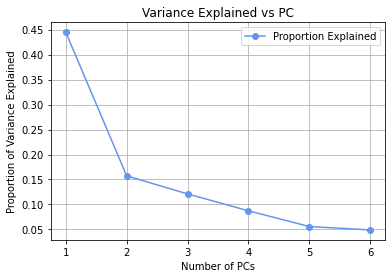

In [77]:
#Setting up the explained variance
expl_var = my_pca.explained_variance_ratio_
#Setting up the plot
plt.figure()
plt.plot(range(1,(X_test_PCA.shape[1]+1),1),expl_var,color='cornflowerblue',label='Proportion Explained',marker='o')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.legend()
plt.title('Variance Explained vs PC')
plt.grid()
plt.show()

It looks like before, where most of the information is just coming froma few dimentionalities. 

Lets Cross validated the data and run a logistic regression to score this

In [78]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

### 5-fold cross validation
cross_validation_scores = []
# The C_values to try
C_values = [.00001,0.0001,0.001, 0.01, 0.1, 1, 10, 100,1000]

#Do some cross validation
for c in tqdm(C_values):
    #fit the log model
    LR_model = LogisticRegression(C=c,max_iter=100)
    #set the cross validation
    cv_score = np.mean(cross_val_score(LR_model, X_train_PCA, y_train, cv = 5))
    #gather the scores for validation
    cross_validation_scores.append(cv_score)

100%|██████████| 9/9 [00:21<00:00,  2.36s/it]


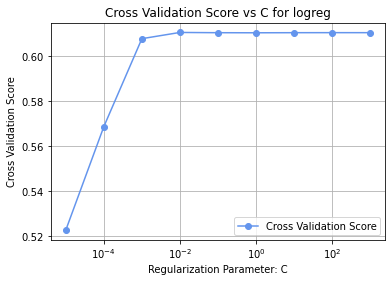

The best model has C =  0.01


In [79]:
# Plot
plt.figure()
plt.plot(C_values, cross_validation_scores,c='cornflowerblue',label="Cross Validation Score",marker='o')
plt.legend()
plt.title('Cross Validation Score vs C for logreg')
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')

plt.grid()
plt.show();

which_max = np.array(cross_validation_scores).argmax()

print("The best model has C = ",C_values[which_max])

In [103]:
# Lets print the score of the highest 
# Instantiate the model
log_reg = LogisticRegression(C=C_values[which_max],max_iter=100)

# Fit the model 
log_reg.fit(X_train_PCA,y_train)

# evaluate on train & test sets
print(f'Train Score for Logistical Regression = {round(log_reg.score(X_train_PCA, y_train),3)}')
print(f'Test Score for Logistical Regression = {round(log_reg.score(X_test_PCA, y_test),3)}')

Train Score for Logistical Regression = 0.61
Test Score for Logistical Regression = 0.611


Looks like the scores have taken a dip but that is expected as we have added more data and more players to the model. <br> lets take a closer look at the log reg model

100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


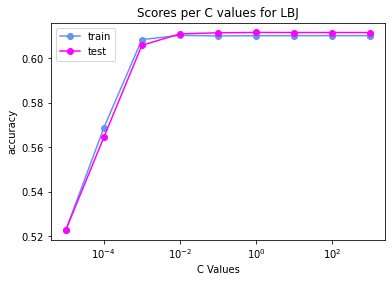

5.794203758239746


In [104]:
from sklearn.linear_model import LogisticRegression

start = time.time()
# Create lists to hold our accuracies
train_acc = []
test_acc = []

# The C_values to try
C_values = [.00001,0.0001,0.001, 0.01, 0.1, 1, 10, 100,1000]



# Loop through the C values 
for C in tqdm(C_values):

    # Instantiate the model
    log_reg = LogisticRegression(C=C,max_iter=1000,solver='lbfgs')

    # Fit the model 
    log_reg.fit(X_train_PCA,y_train)

    # Score the model 
    train_acc.append(log_reg.score(X_train_PCA,y_train))
    test_acc.append(log_reg.score(X_test_PCA,y_test))

# plot the results
plt.figure()
plt.plot(C_values,train_acc, c='cornflowerblue', label='train', marker="o")
plt.plot(C_values,test_acc, c='fuchsia', label='test', marker="o")
plt.title('Scores per C values for LBJ')
plt.xlabel('C Values')
plt.ylabel('accuracy')
plt.xscale('log')
plt.legend()
plt.show()

end=time.time()
print(end-start)

Now lets evaluate the model 

In [107]:
#Lets get the confusion Matrix
from sklearn.metrics import confusion_matrix

y_pred = log_reg.predict(X_test_PCA)

# True values first, predicted values second
confusion_matrix(y_test, y_pred)

array([[11465,  3166,   907],
       [  615,  4587,  1941],
       [  551,  4365,  2124]])

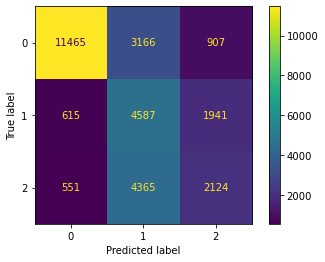

In [108]:
#Lets get the nicer display
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [109]:
#Lets get the classification report
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

precision    recall  f1-score   support

           0       0.91      0.74      0.81     15538
           1       0.38      0.64      0.48      7143
           2       0.43      0.30      0.35      7040

    accuracy                           0.61     29721
   macro avg       0.57      0.56      0.55     29721
weighted avg       0.67      0.61      0.62     29721



In [110]:
#lets get the the value counts
idk['Shot Zone Area'].value_counts(normalize=True)

0    0.522755
1    0.242283
2    0.234962
Name: Shot Zone Area, dtype: float64

As we can see here, the Logestic Regression here is giving the same problem as below. Just a shmall difference in differential is causing such a big difference in the recall value. <br>
Now we will try something different, lets try a Gird Search, maybe we are missing something.

In [105]:
# Set up the (placeholder) pipeline 
pipeline = Pipeline([('scale', MinMaxScaler()),
                    ('decompose', PCA()),
                    ('model', LogisticRegression())])

# Set up the parameter grid
param_grid = [
            {
                'scale':[MinMaxScaler(), StandardScaler()],
                'model':[LogisticRegression(max_iter=1000000)],
                'decompose':[PCA()],
                'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'model__penalty':['l1','l2'],
                'model__solver':['lbfgs', 'liblinear', 'saga'],
                'decompose__n_components': [.9]
                
            }, {
                'scale':[MinMaxScaler(), StandardScaler()],
                'model':[RandomForestClassifier()],
                'decompose':[PCA()],
                'model__max_depth': [1,2,3,4,5,7],
                'decompose__n_components': [.9]
            }, {
                'scale':[MinMaxScaler(), StandardScaler()],
                'model':[GradientBoostingClassifier()],
                'decompose':[PCA()],
                'model__max_depth': [1,2,3,4,5],
                'decompose__n_components': [.9]
            }, {
                'scale':[MinMaxScaler(), StandardScaler()],
                'model':[MultinomialNB()],
                'decompose':[PCA()],
                'model__alpha': [0.00001,0.0001, 0.001, 0.01, 0.1, 1, 2],
                'decompose__n_components': [.9]
            }]
            
# Instantiate the grid search
my_gridsearch = GridSearchCV(pipeline, param_grid, n_jobs=3,verbose=1)

# Fit the grid search
my_gridsearch.fit(X_train_PCA,y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  62 tasks      | elapsed:   10.9s
[Parallel(n_jobs=3)]: Done 212 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 462 tasks      | elapsed:  9.1min
[Parallel(n_jobs=3)]: Done 600 out of 600 | elapsed: 28.8min finished


GridSearchCV(estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('decompose', PCA()),
                                       ('model', LogisticRegression())]),
             n_jobs=3,
             param_grid=[{'decompose': [PCA()],
                          'decompose__n_components': [0.9],
                          'model': [LogisticRegression(max_iter=1000000)],
                          'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'model__penalty': ['l1', 'l2'],
                          'model__solver': ['lbfgs', 'liblinear', 'sag...
                         {'decompose': [PCA(n_components=0.9)],
                          'decompose__n_components': [0.9],
                          'model': [GradientBoostingClassifier()],
                          'model__max_depth': [1, 2, 3, 4, 5],
                          'scale': [MinMaxScaler(), StandardScaler()]},
                         {'decompose': [PCA()],
           

In [111]:
# Best estimator object
my_gridsearch.best_estimator_

Pipeline(steps=[('scale', MinMaxScaler()), ('decompose', PCA(n_components=0.9)),
                ('model', GradientBoostingClassifier())])

Looks like the best score here is coming from the Gradiant Boosting. Lets check the scores and the Matrix

In [118]:
#Scores
print(my_gridsearch.score(X_train_PCA, y_train))
print(my_gridsearch.score(X_test_PCA, y_test))

0.626141888595414
0.6136401870731133


In [119]:
#Confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = my_gridsearch.predict(X_test_PCA)

# True values first, predicted values second
confusion_matrix(y_test, y_pred)

array([[11563,  2925,  1050],
       [  703,  4342,  2098],
       [  615,  4092,  2333]])

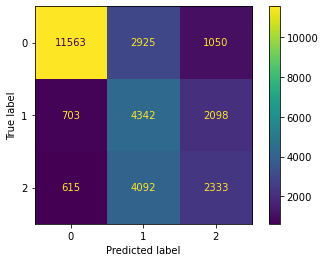

In [120]:
#Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [117]:
#Classification Report 
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

precision    recall  f1-score   support

           0       0.90      0.74      0.81     15538
           1       0.38      0.61      0.47      7143
           2       0.43      0.33      0.37      7040

    accuracy                           0.61     29721
   macro avg       0.57      0.56      0.55     29721
weighted avg       0.66      0.61      0.63     29721



Its better by .03, in other words still really poor. Lets keep discovering better ways to fix this

In [121]:
#Normalized Values
idk['Shot Zone Area'].value_counts(normalize=True)

0    0.522755
1    0.242283
2    0.234962
Name: Shot Zone Area, dtype: float64

Grid Search NN

Lets try Neural Networks, and see if they are able to fix this issue that we are facing

In [124]:
#Set up the (placeholder) pipeline 
pipeline = Pipeline([('scale', MinMaxScaler()),
                    ('decompose', PCA()),
                    ('model', LogisticRegression())])

# Set up the parameter grid
param_grid = [
            {
                'scale':[MinMaxScaler(), StandardScaler()],
                'model':[MLPClassifier()],
                'decompose':[PCA()],
                'model__solver':['sgd','Adam'],
                'model__hidden_layer_sizes':np.arange(5, 12),
                'model__alpha': 10.0 ** -np.arange(1, 7),
                'decompose__n_components': [.9]
            } ]
            
# Instantiate the grid search
my_gridsearch = GridSearchCV(pipeline, param_grid, n_jobs=4,verbose=1)

# Fit the grid search
my_gridsearch.fit(X_train,y_train)
print("-----------------Original Features--------------------")
print("Best score: %0.4f" % my_gridsearch.best_score_)
print("Using the following parameters:")
print(my_gridsearch.best_params_)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   54.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  7.8min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 13.5min
[Parallel(n_jobs=4)]: Done 840 out of 840 | elapsed: 14.3min finished
-----------------Original Features--------------------
Best score: 0.6121
Using the following parameters:
{'decompose': PCA(n_components=0.9), 'decompose__n_components': 0.9, 'model': MLPClassifier(alpha=1e-05, hidden_layer_sizes=5, solver='sgd'), 'model__alpha': 1e-05, 'model__hidden_layer_sizes': 5, 'model__solver': 'sgd', 'scale': StandardScaler()}


In [125]:
# Best estimator object
my_gridsearch.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('decompose', PCA(n_components=0.9)),
                ('model',
                 MLPClassifier(alpha=1e-05, hidden_layer_sizes=5,
                               solver='sgd'))])

In [126]:
print(my_gridsearch.score(X_train, y_train))
print(my_gridsearch.score(X_test, y_test))

0.6122878148079608
0.604791225059722


In [127]:
#Confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = my_gridsearch.predict(X_test)

# True values first, predicted values second
confusion_matrix(y_test, y_pred)

array([[11509,  3187,   842],
       [  650,  4638,  1855],
       [  571,  4641,  1828]])

In [128]:
#Classification Report 
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

precision    recall  f1-score   support

           0       0.90      0.74      0.81     15538
           1       0.37      0.65      0.47      7143
           2       0.40      0.26      0.32      7040

    accuracy                           0.60     29721
   macro avg       0.56      0.55      0.53     29721
weighted avg       0.66      0.60      0.61     29721



It seems that the neural network ran a bit more poorly in terms of score, and the report was also considerably worse. <br>

Lets now try and see what happens if we raise the weights for at logistic regression, to more balance the classifications

Log reg

In [133]:
# Instantiate the model
#We have raised the weights by using class_weights in our model
log_reg = LogisticRegression(C=1,max_iter=100000,solver='liblinear',class_weight={0:1,1:2,2:2.2},random_state=1)

# Fit the model 
log_reg.fit(X_train_PCA,y_train)

# evaluate on train & test sets
print(f'Train Score for Logistical Regression = {round(log_reg.score(X_train_PCA, y_train),3)}')
print(f'Test Score for Logistical Regression = {round(log_reg.score(X_test_PCA, y_test),3)}')

Train Score for Logistical Regression = 0.605
Test Score for Logistical Regression = 0.61


In [130]:
#Lets check the matrix 
from sklearn.metrics import confusion_matrix

y_pred = log_reg.predict(X_test_PCA)

# True values first, predicted values second
confusion_matrix(y_test, y_pred)

array([[10824,  2666,  2048],
       [    0,  3434,  3709],
       [    3,  3173,  3864]])

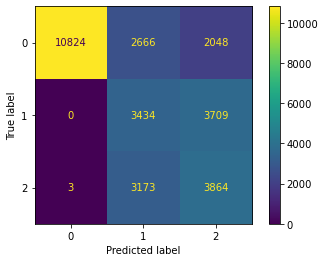

In [134]:
#Matrix with nicer display
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [135]:
#Lets check the classification report
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

precision    recall  f1-score   support

           0       1.00      0.70      0.82     15538
           1       0.37      0.48      0.42      7143
           2       0.40      0.55      0.46      7040

    accuracy                           0.61     29721
   macro avg       0.59      0.58      0.57     29721
weighted avg       0.71      0.61      0.64     29721



In [136]:
#Normalized values to compare
idk['Shot Zone Area'].value_counts(normalize=True)

0    0.522755
1    0.242283
2    0.234962
Name: Shot Zone Area, dtype: float64

Wow, now this is much better! We have raised the recall score drastically. It is alot more even now, and the accuracy doesnt really fall either. We can now use this to better predict scores of the players,
and the model doesnt bias itself from the right and left as much anymore!